In [ ]:
import warnings; warnings.simplefilter('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import datetime
import os

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
plt.rcParams["figure.figsize"] = (17,7)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

import gc
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [ ]:
!ls

ASHRAE_Energy_Prediction.ipynb	kaggle.json


In [ ]:
# Due to the dataset size we will use Kaggle API to downoad the data.
# You need to authenticate using an API token.
# To generte the Token, please go to your Kaggle Profile -> Account -> Create new Token 
# then upload/move the “kaggle.json” file to your working directory.
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle competitions download -c ashrae-energy-prediction

 97% 369M/379M [00:12<00:00, 19.0MB/s]
100% 379M/379M [00:12<00:00, 32.5MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("ashrae-energy-prediction.zip","r") as zip_ref:
    zip_ref.extractall("./Data")

In [ ]:
!ls ./Data

building_metadata.csv  test.csv   weather_test.csv
sample_submission.csv  train.csv  weather_train.csv


In [ ]:
cd ./Data

/content/drive/MyDrive/ASHRAE_Project/Data


# Pre-processing:








In [ ]:
train_df=pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
weather_train_df = pd.read_csv('weather_train.csv')
weather_test_df = pd.read_csv('weather_test.csv')
building_meta_df = pd.read_csv('building_metadata.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
## Function to reduce the Data frames size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)
#sample_submission = reduce_mem_usage(sample_submission)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
#function to have an overal statistical view on each dataframe
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    statitics['UNIQUE VALUES'] = df.nunique().reset_index()[0]
    return statitics

## Basic look at the dataset:

In [ ]:
train_df.head(10)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0
5,5,0,2016-01-01 00:00:00,0.0
6,6,0,2016-01-01 00:00:00,0.0
7,7,0,2016-01-01 00:00:00,0.0
8,8,0,2016-01-01 00:00:00,0.0
9,9,0,2016-01-01 00:00:00,0.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int16  
 1   meter          int8   
 2   timestamp      object 
 3   meter_reading  float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 289.2+ MB


In [ ]:
missing_statistics(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING,UNIQUE VALUES
0,building_id,0,20216100,0.0,1449
1,meter,0,20216100,0.0,4
2,timestamp,0,20216100,0.0,8784
3,meter_reading,0,20216100,0.0,1688175


> Observations:
* The dataset contains *8784 unique timestamps* which was expected: 
`8784 = 366 * 24`
* The dataset contains *4 different meter types* and *1449 unique buildings*.
* If every building has a reading for any meter type at any timestamp we will have `4 * 1449 * 8784 = 50912064` entries, which is significantly higher than the total number of entires 20216100.


> Possibilities:
* We have some missing entries.
* Some buildings are not equiped with some meter types.
















array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d83feadd0>,
      dtype=object)

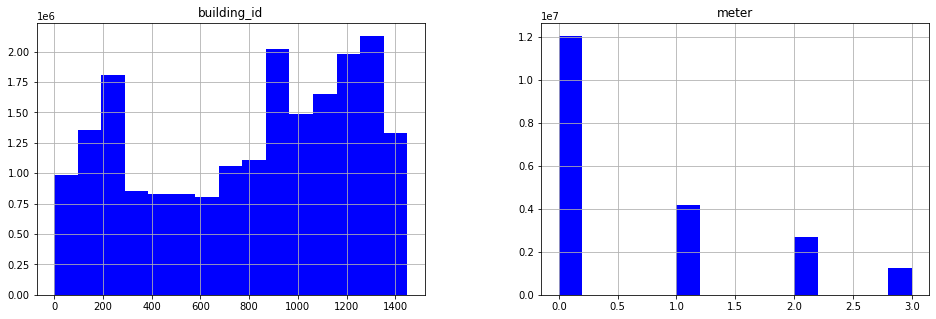

In [ ]:
train_df[["building_id", "meter"]].hist(figsize=(16,5),color="blue",bins=15)

In [ ]:
# Distribution of the different meter types:
meter_dist = train_df[['building_id','meter']].groupby(['meter'], as_index=True).nunique()
meter_dist.columns = ["# Buildings"]
meter_dist

,# Buildings
meter,
0,1413
1,498
2,324
3,145


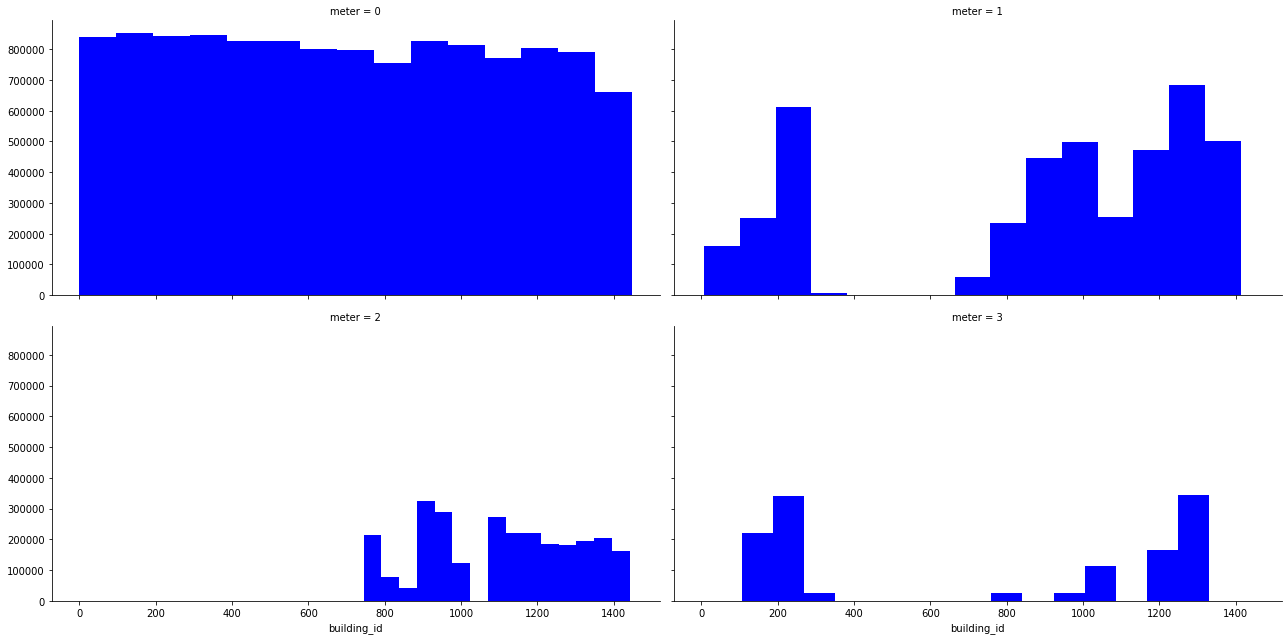

In [ ]:
meter_mapping = sns.FacetGrid(train_df, col='meter', col_wrap=2, height=4.5, aspect=2)
meter_mapping.map(plt.hist, 'building_id', bins=15, color='blue');

Based on the figures above, we can conclude that our assumption is correct: 
* The most common meter type is type 0. 
* Multiple buildings don't have meter types 1-3.

=> Unbalanced dataset: meter type 0 (electrecity) is dominating the dataset.

In [ ]:
weather_train_df.head(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609
5,0,2016-01-01 05:00:00,19.406250,NaN,19.40625,0.0,NaN,0.0,0.000000
6,0,2016-01-01 06:00:00,21.093750,6.0,21.09375,-1.0,1019.5,0.0,0.000000
7,0,2016-01-01 07:00:00,21.093750,NaN,21.09375,0.0,1019.0,210.0,1.500000
8,0,2016-01-01 08:00:00,20.593750,NaN,20.00000,0.0,1018.0,0.0,0.000000
9,0,2016-01-01 09:00:00,21.093750,NaN,20.59375,0.0,1019.0,290.0,1.500000


In [ ]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int8   
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float16
 3   cloud_coverage      70600 non-null   float16
 4   dew_temperature     139660 non-null  float16
 5   precip_depth_1_hr   89484 non-null   float16
 6   sea_level_pressure  129155 non-null  float16
 7   wind_direction      133505 non-null  float16
 8   wind_speed          139469 non-null  float16
dtypes: float16(7), int8(1), object(1)
memory usage: 3.1+ MB


In [ ]:
missing_statistics(weather_train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING,UNIQUE VALUES
0,site_id,0,139773,0.00,16
1,timestamp,0,139773,0.00,8784
2,air_temperature,55,139773,0.04,619
3,cloud_coverage,69173,139773,49.49,10
4,dew_temperature,113,139773,0.08,522
5,precip_depth_1_hr,50289,139773,35.98,128
6,sea_level_pressure,10618,139773,7.60,133
7,wind_direction,6268,139773,4.48,43
8,wind_speed,304,139773,0.22,58


> Observations:
* A lot of missing values for cloud_coverage and precip_depth_1_hr. We should probably drop those features.
* The dataset contains *16 unique sites*, therefore we are supposed to have ```
16 * 8784 = 140544 ``` entries, recording the weather in every site at any time. 

=> We can conclude that we have some missing values.

In [ ]:
building_meta_df.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


In [ ]:
building_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int8   
 1   building_id  1449 non-null   int16  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int32  
 4   year_built   675 non-null    float16
 5   floor_count  355 non-null    float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB


In [ ]:
missing_statistics(building_meta_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING,UNIQUE VALUES
0,site_id,0,1449,0.00,16
1,building_id,0,1449,0.00,1449
2,primary_use,0,1449,0.00,16
3,square_feet,0,1449,0.00,1397
4,year_built,774,1449,53.42,116
5,floor_count,1094,1449,75.50,18


In [ ]:
building_meta_df["primary_use"].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

> Observations:
* A lot of missing values for year_built and floor count. We should probably drop those features.
* Exploring the the distribution of the buildings by location (site_id) and industry (primary_use) can give us valuable insights.

In [ ]:
le = LabelEncoder()  #encode primary use instead of using string type.

building_meta_df['primary_use'] = le.fit_transform(building_meta_df['primary_use']).astype(np.int8)

In [ ]:
le.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage'], dtype=object)

In [ ]:
building_meta_df['primary_use']

0       0
1       0
2       0
3       0
4       0
       ..
1444    1
1445    0
1446    1
1447    4
1448    6
Name: primary_use, Length: 1449, dtype: int8

In [ ]:
# Distribution of the different meter types:
primary_use_dist = building_meta_df[['building_id','primary_use']].groupby(['primary_use'], as_index=True).nunique()
primary_use_dist.columns = ["# Buildings"]
primary_use_dist

,# Buildings
primary_use,
0,549
1,184
2,5
3,23
4,147
5,12
6,279
7,25
8,22


In [ ]:
# Distribution of the different meter types:
site_dist = building_meta_df[['building_id','site_id']].groupby(['site_id'], as_index=True).nunique()
site_dist.columns = ["# Buildings"]
site_dist

,# Buildings
site_id,
0,105
1,51
2,135
3,274
4,91
5,89
6,44
7,15
8,70


As seen above, we have unbalanced distribution, especially for primary use. A third of the buildings are educational buildings. 

In [ ]:
missing_statistics(test_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING,UNIQUE VALUES
0,row_id,0,41697600,0.0,41697600
1,building_id,0,41697600,0.0,1449
2,meter,0,41697600,0.0,4
3,timestamp,0,41697600,0.0,17520


In [ ]:
missing_statistics(weather_test_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING,UNIQUE VALUES
0,site_id,0,277243,0.00,16
1,timestamp,0,277243,0.00,17520
2,air_temperature,104,277243,0.04,639
3,cloud_coverage,140448,277243,50.66,10
4,dew_temperature,327,277243,0.12,559
5,precip_depth_1_hr,95588,277243,34.48,174
6,sea_level_pressure,21265,277243,7.67,130
7,wind_direction,12370,277243,4.46,60
8,wind_speed,460,277243,0.17,78


In [ ]:
#missing_statistics(sample_submission)

## Converting "timestamps" to pandas datetime & Features engineering:



In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

#building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [ ]:
#Energy consumption will differ based on the nature of the day: for instance, in the weekend a school is usually closed. 
#Feature engineering: deriving the nature of the day.

dates = pd.date_range(train_df['timestamp'].min(), test_df['timestamp'].max() ,freq = 'D')
business_days = pd.date_range(train_df['timestamp'].min(), test_df['timestamp'].max() ,freq = 'B')  #Does not take into consideration the holidays
weekends = dates.difference(business_days)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
calendar = calendar()
holidays = pd.to_datetime(calendar.holidays(start=train_df['timestamp'].min(), end=test_df['timestamp'].max()))

real_business_days = business_days.difference(holidays)

In [ ]:
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["date"] = pd.to_datetime(train_df["timestamp"].dt.date)
train_df["month"] = train_df["timestamp"].dt.month
train_df["weekday"] = train_df["timestamp"].dt.weekday #Return The day of the week with Monday=0, Sunday=6.
train_df["weekend"] = np.int8(train_df["date"].isin(weekends)) #Boolean variable
train_df['holiday'] = np.int8(train_df["date"].isin(holidays)) #Boolean variable
train_df['business_day'] = np.int8(train_df["date"].isin(real_business_days)) #Boolean variable

test_df["hour"] = test_df["timestamp"].dt.hour
test_df["date"] = pd.to_datetime(test_df["timestamp"].dt.date)
test_df["month"] = test_df["timestamp"].dt.month
test_df["weekday"] = test_df["timestamp"].dt.weekday
test_df['weekend'] = np.int8(test_df["date"].isin(weekends))
test_df['holiday'] = np.int8(test_df["date"].isin(holidays))
test_df['business_day'] = np.int8(test_df["date"].isin(real_business_days))

In [ ]:
reduce_mem_usage(train_df)

Mem. usage decreased to 559.11 Mb (42.0% reduction)


,building_id,meter,timestamp,meter_reading,hour,date,month,weekday,weekend,holiday,business_day
0,0,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
1,1,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
2,2,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
3,3,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
4,4,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,2016-12-31,12,5,1,0,0
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,2016-12-31,12,5,1,0,0
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,2016-12-31,12,5,1,0,0
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,2016-12-31,12,5,1,0,0


In [ ]:
train_df

,building_id,meter,timestamp,meter_reading,hour,date,month,weekday,weekend,holiday,business_day
0,0,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
1,1,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
2,2,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
3,3,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
4,4,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,2016-12-31,12,5,1,0,0
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,2016-12-31,12,5,1,0,0
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,2016-12-31,12,5,1,0,0
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,2016-12-31,12,5,1,0,0


In [ ]:
del dates, business_days, real_business_days, calendar, holidays, weekends
gc.collect()

108

In [ ]:
drop_cols = ['cloud_coverage','dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weather_train_df = weather_train_df.drop(drop_cols, axis=1)
weather_test_df = weather_test_df.drop(drop_cols, axis=1)
building_meta_df = building_meta_df.drop(['year_built', 'floor_count'], axis=1)

In [ ]:
reduce_mem_usage(weather_train_df)
reduce_mem_usage(weather_test_df)
reduce_mem_usage(building_meta_df)

Mem. usage decreased to  1.47 Mb (0.0% reduction)
Mem. usage decreased to  2.91 Mb (0.0% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)


,site_id,building_id,primary_use,square_feet
0,0,0,0,7432
1,0,1,0,2720
2,0,2,0,5376
3,0,3,0,23685
4,0,4,0,116607
...,...,...,...,...
1444,15,1444,1,19619
1445,15,1445,0,4298
1446,15,1446,1,11265
1447,15,1447,4,29775


In [ ]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df

In [ ]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

In [ ]:
train_df

,building_id,meter,timestamp,meter_reading,hour,date,month,weekday,weekend,holiday,business_day,site_id,primary_use,square_feet,air_temperature
0,0,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0,0,0,7432,25.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0,0,0,2720,25.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0,0,0,5376,25.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0,0,0,23685,25.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,2016-01-01,1,4,0,1,0,0,0,116607,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,2016-12-31,12,5,1,0,0,15,1,19619,1.700195
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,2016-12-31,12,5,1,0,0,15,0,4298,1.700195
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,2016-12-31,12,5,1,0,0,15,1,11265,1.700195
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,2016-12-31,12,5,1,0,0,15,4,29775,1.700195


## Visualization and correlation study:

In [ ]:
edu_1 = train_df.loc[train_df['building_id'] == 1]
ent_10 = train_df.loc[train_df['building_id'] == 10]
food_179 = train_df.loc[train_df['building_id'] == 179]
health_208 = train_df.loc[train_df['building_id'] == 208]
lodg_6 = train_df.loc[train_df['building_id'] == 16]
inds_672 = train_df.loc[train_df['building_id'] == 672]
office_9 = train_df.loc[train_df['building_id'] == 9]
other_42 = train_df.loc[train_df['building_id'] == 42]
parking_51 = train_df.loc[train_df['building_id'] == 51]
public_138 = train_df.loc[train_df['building_id'] == 138]
relig_186 = train_df.loc[train_df['building_id'] == 186]
serv_892 = train_df.loc[train_df['building_id'] == 892]
tech_575 = train_df.loc[train_df['building_id'] == 575]
util_285 = train_df.loc[train_df['building_id'] == 285]
storage_164 = train_df.loc[train_df['building_id'] == 164]

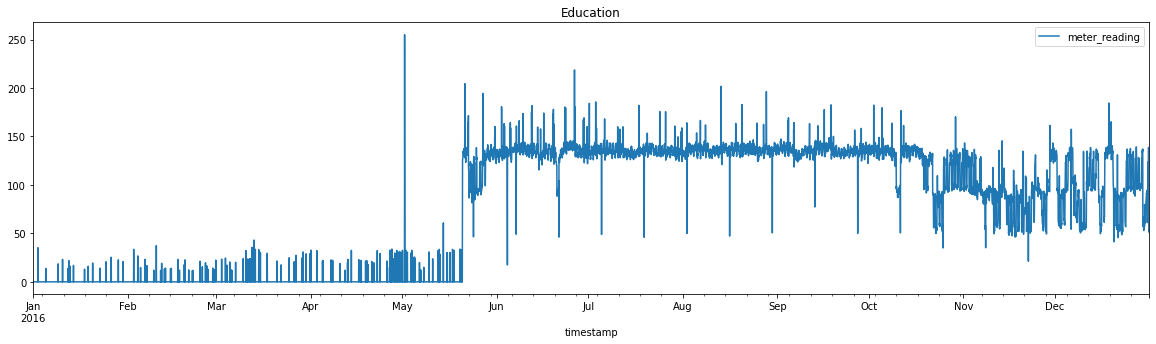

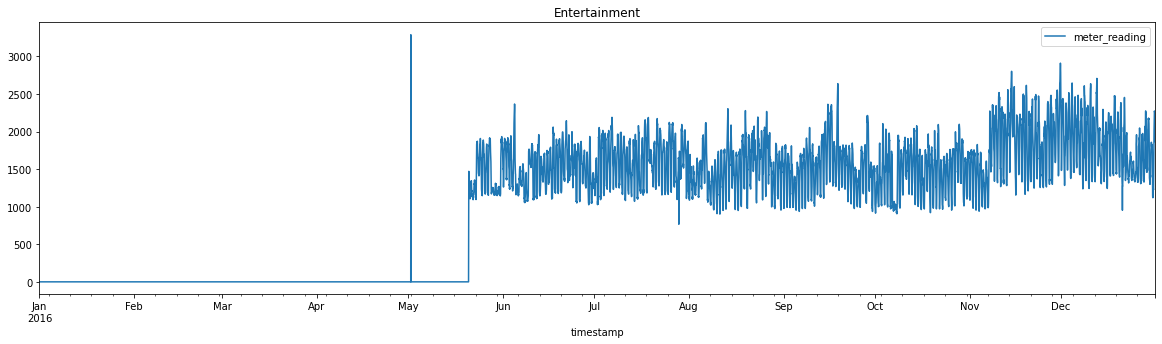

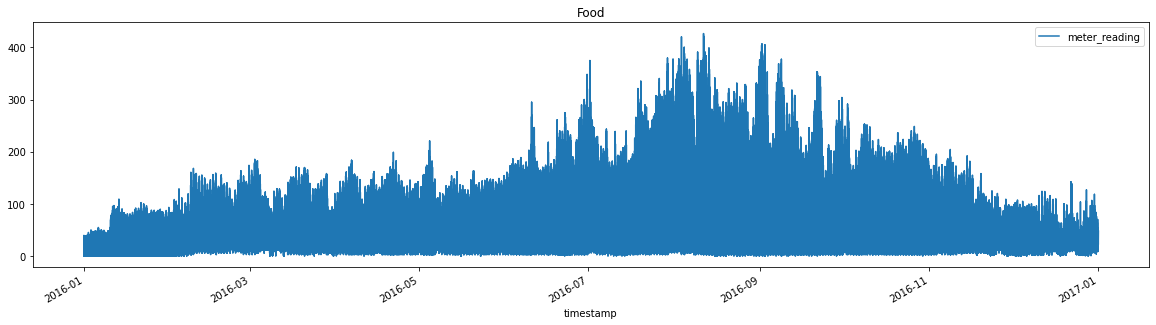

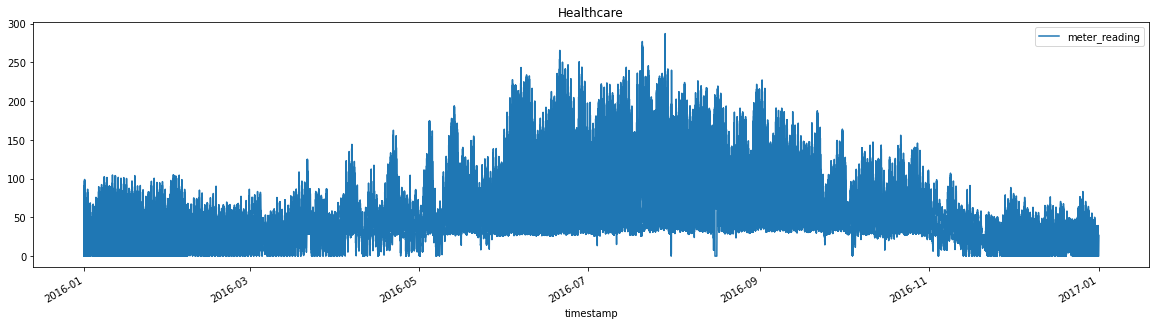

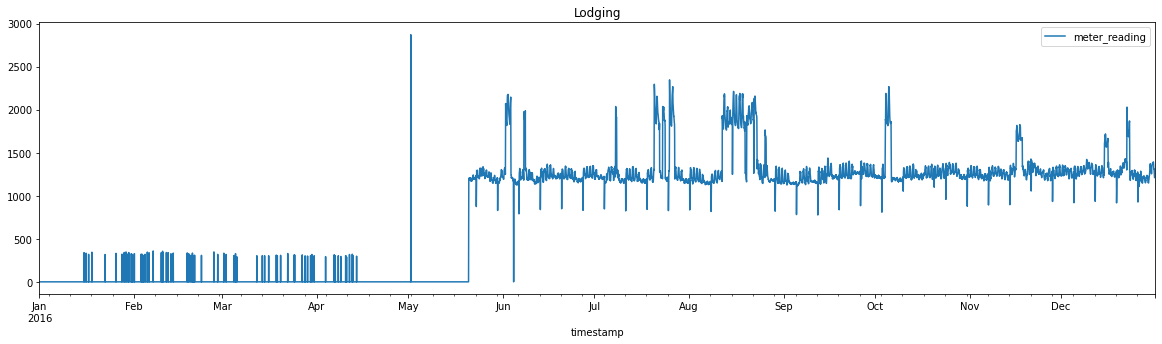

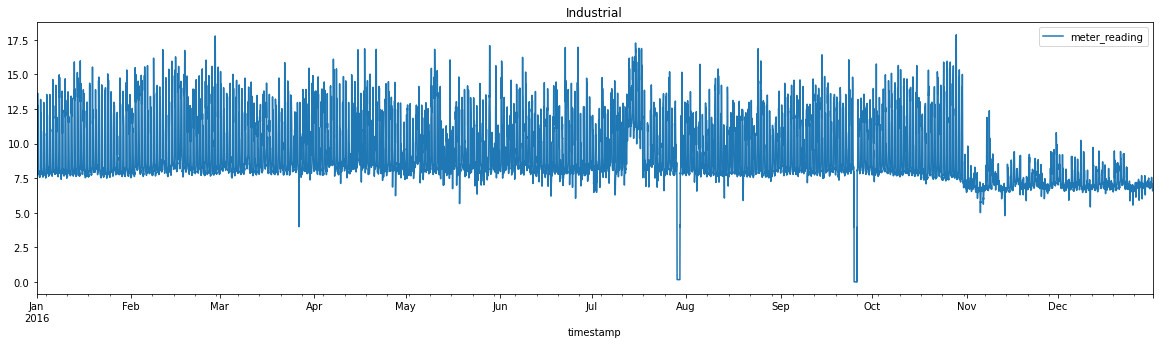

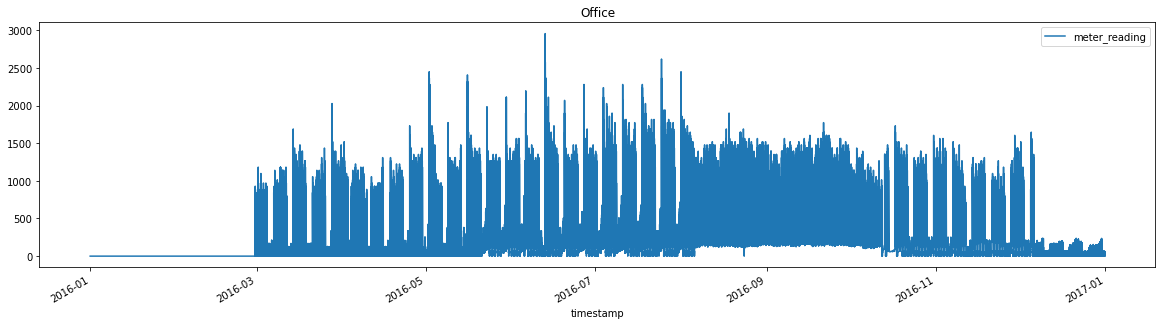

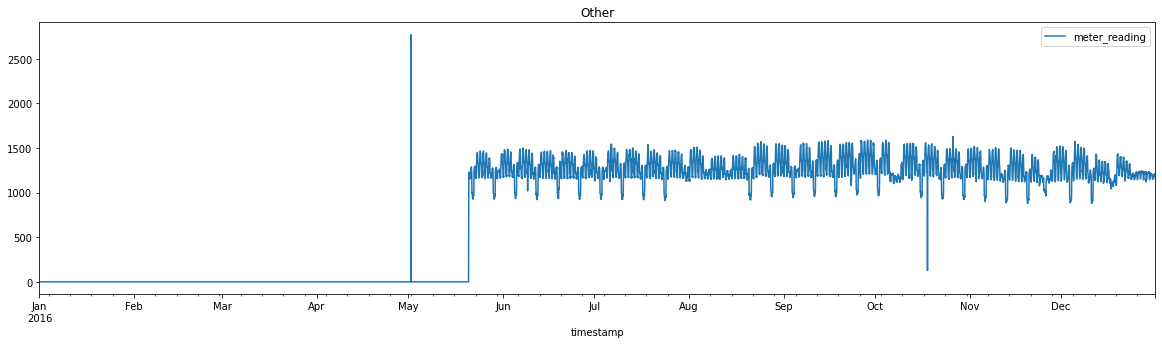

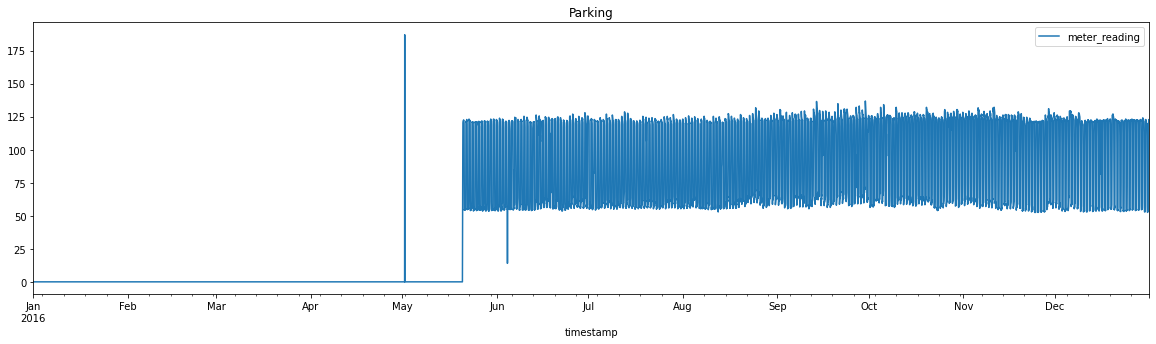

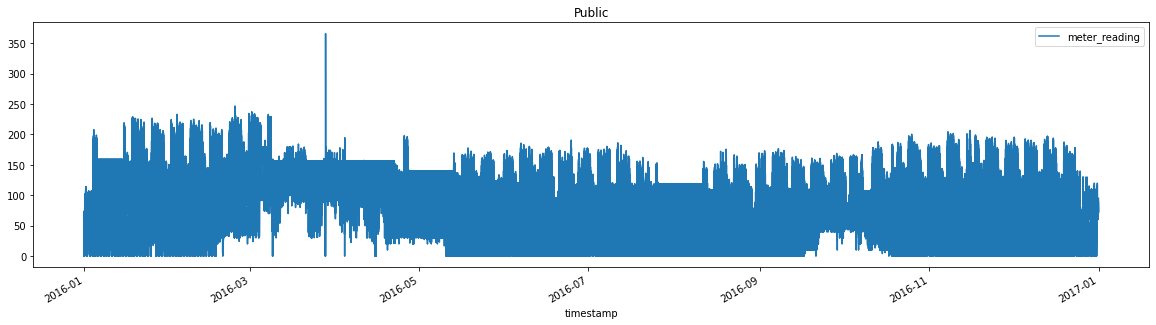

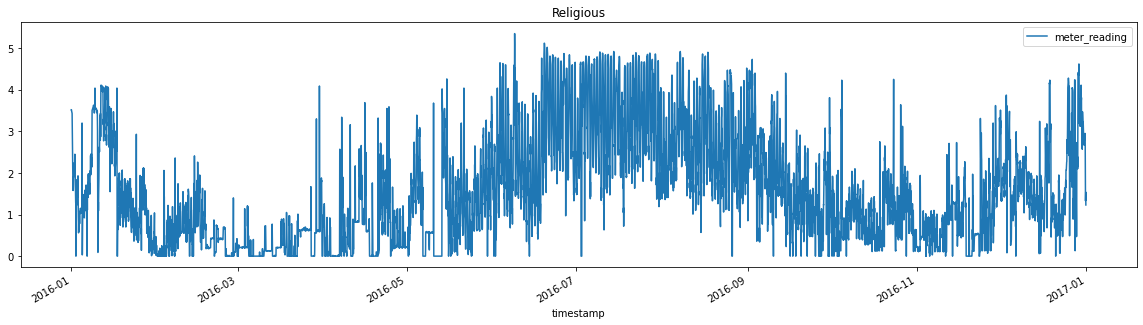

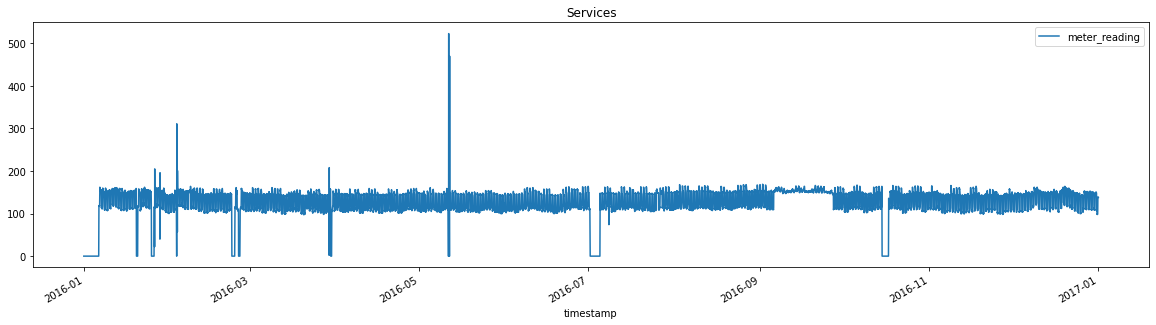

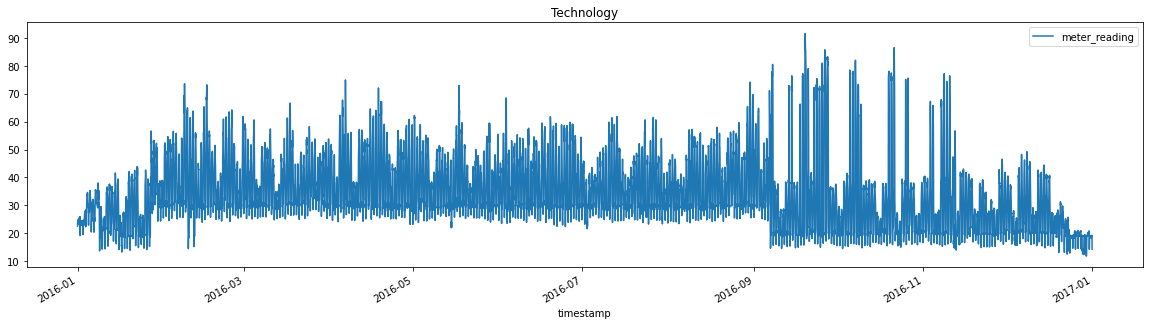

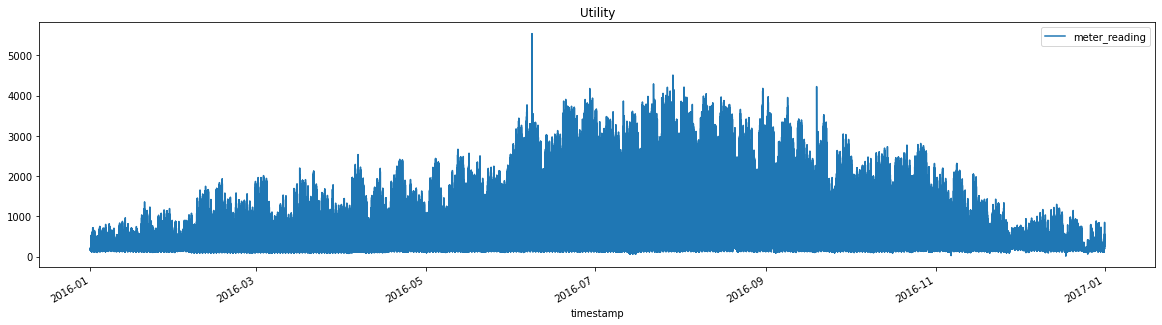

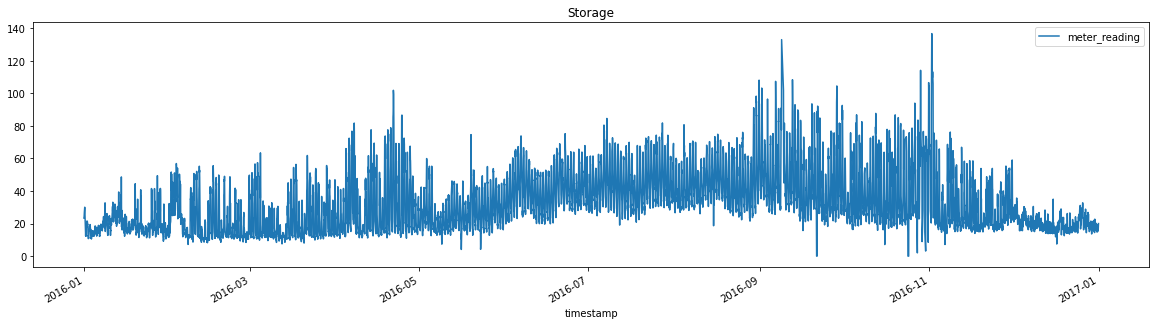

In [ ]:
edu_1.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Education")
ent_10.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Entertainment")
food_179.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Food")
health_208.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Healthcare")
lodg_6.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Lodging")
inds_672.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Industrial")
office_9.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Office")
other_42.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Other")
parking_51.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Parking")
public_138.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Public")
relig_186.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Religious")
serv_892.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Services")
tech_575.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Technology")
util_285.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Utility")
storage_164.plot.line(x='timestamp', y='meter_reading',figsize=(20,5), title="Storage")

In [ ]:
#categoricals = ["building_id", "primary_use", "hour", "date", "month", "weekend", "holiday", "business_day", "meter", "year_built"]
#numericals = ["square_feet", "meter_reading" ,"air_temperature", "cloud_coverage","dew_temperature"]

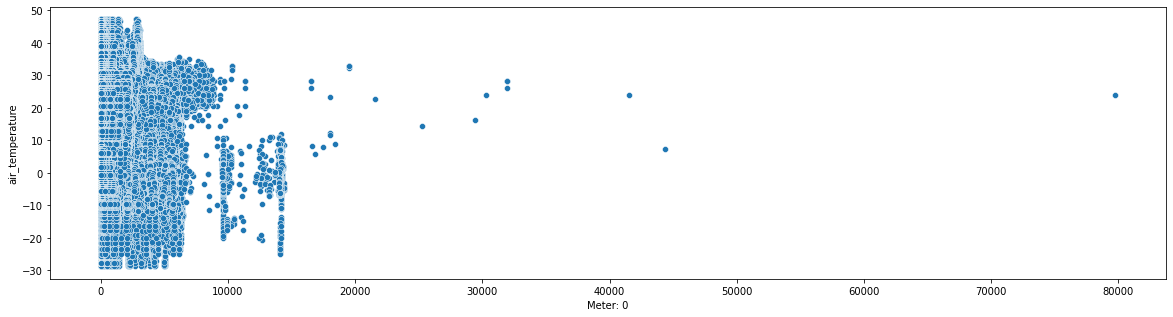

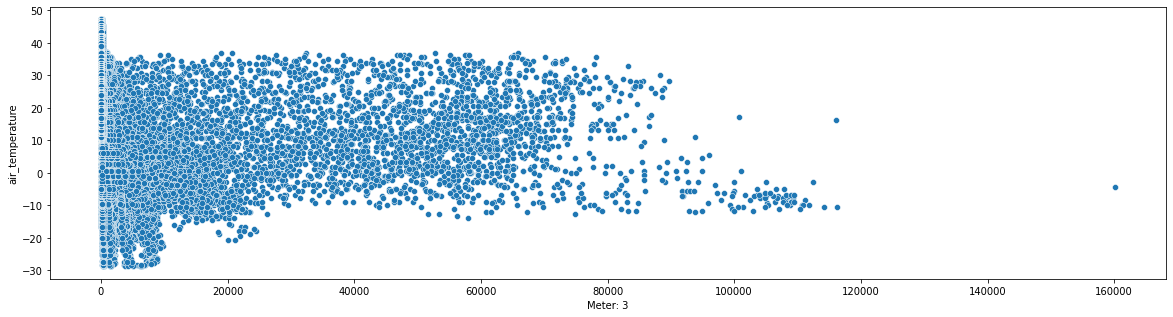

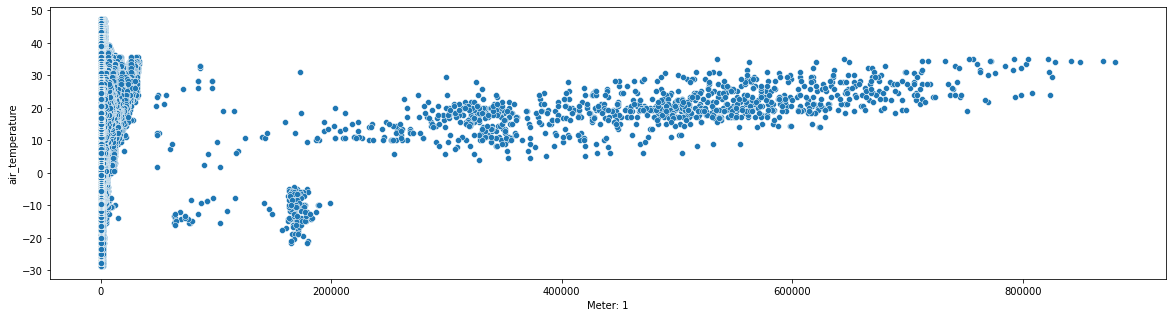

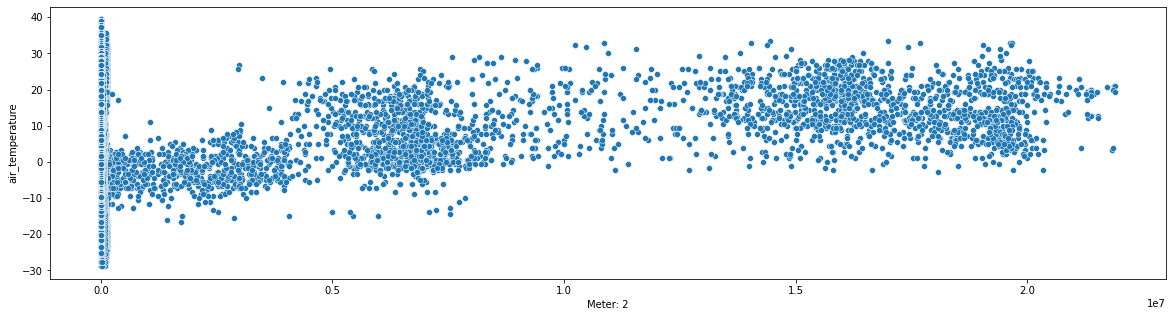

In [ ]:
#set meter between 0-3 and for each meter to find abnormal meter_reading values for air_temerature

meter_arr = train_df["meter"].unique()
for meter in meter_arr:
    mask = train_df["meter"] == meter
    plt.figure(figsize=(20, 5))
    sns.scatterplot(data = train_df[mask], x = "meter_reading", y = "air_temperature")
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

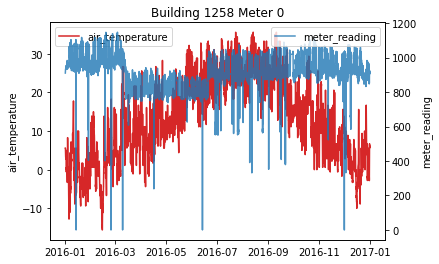

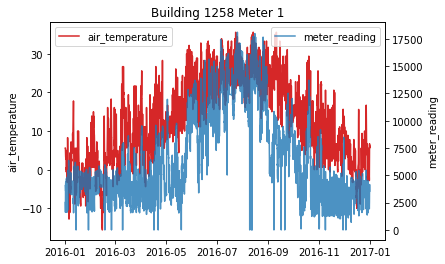

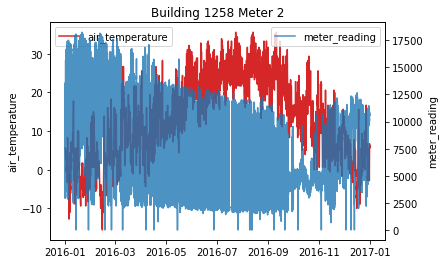

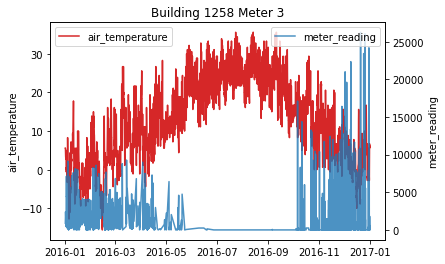

In [ ]:
building_id = 1258  # building 1258 plot meter_reading and air_temperature value for a building with all 4 meters    # or building 1293
meters = train_df[train_df['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train_df['building_id'] == building_id) & (train_df['meter'] == meter)
    dates = matplotlib.dates.date2num(train_df.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train_df.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train_df.loc[train_df['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train_df.loc[train_df['building_id'] == building_id, 'air_temperature'], '-', color='tab:red', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

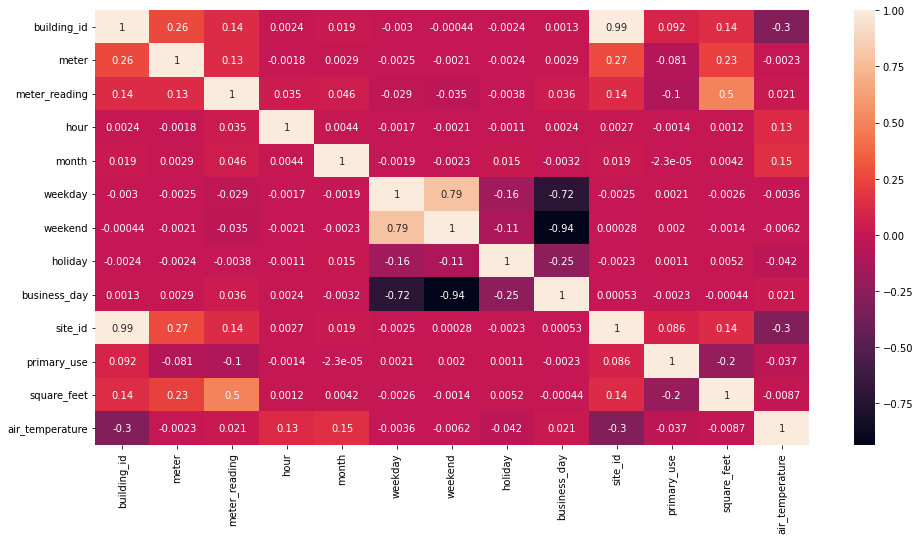

In [ ]:
##  pearson correlation vs spearman to analyse continuous data as well as ordinal data
fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
# plot train in all columns taking 100100 random samples, checking correlation using the method 'spearman'
corr = train_df[[col for col in train_df.columns]].sample(100100).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)